# Baltimore Ravens Free Agent Value Prediction Challenge

Modeling tutorial

## Load libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

## Load data

We use the combined dataset from the starter code.

In [3]:
data = pd.read_csv('./mdst-nfl-free-agents/contracts_players_perf.csv', index_col=0)
data.head()

,player_id_otc,Team,team_id,Position,Role,Years,date_signed,year_signed,start_year,Total,...,pass_snaps,receiving_snaps,passblock_snaps,run_snaps,runblock_snaps,rundefense_snaps,passrush_snaps,coverage_snaps,total_snaps,games
0,51,49ers,31,43OLB,Defense,6,NaN,2012,2012,40400000,...,0.0,0.0,0.0,0.0,0.0,387.0,555.0,180.0,1122.0,18.0
1,53,Vikings,24,LG,Offense,4,NaN,2016,2016,26800000,...,0.0,0.0,478.0,0.0,307.0,0.0,0.0,0.0,785.0,13.0
2,54,Panthers,26,P,Special,2,42792.0,2017,2017,5000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,74,Cowboys,18,C,Offense,2,NaN,2016,2016,1675000,...,0.0,0.0,279.0,0.0,149.0,0.0,0.0,0.0,428.0,8.0
4,79,Raiders,16,WR,Offense,4,NaN,2015,2016,34000000,...,0.0,506.0,0.0,1.0,233.0,0.0,0.0,0.0,740.0,16.0


## Clean for model building

First, we select relevant columns that will be used for prediction. Many columns are not relevant and will be left out. Many of the columns we leave out might actually be relevant and useful, but be careful not to let any information from the contracts leak into your training procedure.

In [4]:
print(data.columns.tolist())

['player_id_otc', 'Team', 'team_id', 'Position', 'Role', 'Years', 'date_signed', 'year_signed', 'start_year', 'Total', 'APY', 'Guarantee', 'GPY', 'GP', 'total_guarantees', 'vested_guarantees', 'signing_bonus', 'option_bonus', 'roster_bonus', 'pergame_bonus', 'workout_bonus', 'incentives', 'FA', 'Status', 'contract_type', 'Accrued', 'height', 'weight', 'DOB', 'college', 'original_team_id', 'draft_year', 'draft_round', 'draft_pick', 'Notes', 'nfl_player_id', 'Name', 'season', 'player_id_pff', 'player', 'pos', 'overall', 'overall_rk', 'pass', 'run', 'receiving', 'passblock', 'runblock', 'passrush', 'rundefense', 'coverage', 'discipline', 'pass_snaps', 'receiving_snaps', 'passblock_snaps', 'run_snaps', 'runblock_snaps', 'rundefense_snaps', 'passrush_snaps', 'coverage_snaps', 'total_snaps', 'games']


In [5]:
predictors = ['Position', 'Role', 'Accrued', 'height', 'weight', 'DOB', 'college', # basic info
              'Years',  'original_team_id', 'draft_year', 'draft_round', 'draft_pick', # basic NFL history
              'overall', 'overall_rk', # pff aggregate grades
              'pass', 'run', 'receiving', 'passblock', 'runblock', 'passrush',
              'rundefense', 'coverage', 'discipline', 'pass_snaps', 'receiving_snaps',
              'passblock_snaps', 'run_snaps', 'runblock_snaps', 'rundefense_snaps', 
              'passrush_snaps', 'coverage_snaps', 'total_snaps', 'games'] # detailed stats from most recent season

target = 'APY'

X = data[predictors]
Y = data[target]

A few preprocessing steps need to happen before we train a model.

- Dummy variables: convert categorical variables into several binary variables
- Imputation: meaningfully handle missing data

### Dummy variables

First, identify all categorical variables. These usually have type "object" (strings)

In [6]:
X.columns[X.dtypes=='object']

Index(['Position', 'Role', 'height', 'DOB', 'college', 'Years', 'overall_rk',
       'pass', 'run', 'receiving', 'passblock', 'runblock', 'passrush',
       'rundefense', 'coverage'],
      dtype='object')

We can see a few of these clearly are not categorical. For example, `height` is coded as a string, which we can fix.

A few others are easily converted to integers or floats without much work.

In [7]:
# Disable copy warning - it's a weird PANDAS thing
pd.options.mode.chained_assignment = None

X = X.replace('\\N', np.nan)
X['Years']      = X['Years'].replace('s', np.nan).astype('float')
X['pass']       = X['pass'].astype('float')
X['run']        = X['run'].astype('float')
X['receiving']  = X['receiving'].astype('float')
X['passblock']  = X['passblock'].astype('float')
X['runblock']   = X['runblock'].astype('float')
X['passrush']   = X['passrush'].astype('float')
X['rundefense'] = X['rundefense'].astype('float')
X['coverage']   = X['coverage'].astype('float')
X['overall_rk'] = X['overall_rk'].astype('float')

X['DOB'] = (pd.datetime(2017, 1, 1) - pd.to_datetime(X.DOB)).apply(lambda x: x.days/365) # now means age

In [8]:
def fixHeight(x):
    if pd.isnull(x) or len(x)<2: return np.nan
    x = x.split('-')
    return int(x[0])*12 + int(x[1])

X['height'] = X['height'].replace(' ', np.nan).apply(fixHeight).astype('float')

Now we actually make the dummy variables. Let's look at the remaining categorical variables:

In [9]:
for col in X.columns[X.dtypes=='object']:
    print(col, ':', len(X[col].value_counts()))

Position : 33
Role : 3
college : 449


For `college`, the number of features would be unmanageable if we make one for each of the 449 schools. We will just use the top 25 colleges instead.

In [10]:
X.college[X.college.isin(X.college.value_counts()[25:].index)] = np.nan

In [11]:
# Finally, make the dummy variables.
X = pd.concat([X, pd.get_dummies(X[['Position', 'Role', 'college']])], axis=1)

X = X.drop(['Position', 'Role', 'college'], axis=1)

### Imputation

One common approach is to replace missing values with the mean value for that feature. However, sometimes it is useful to "remember" which missing values were imputed, so we also add a second column to show which values were imputed.

In [12]:
for col in X.columns:
    if X[col].isnull().any():
        X[col+'_nan']= X[col].isnull()
        X[col] = X[col].fillna(X[col].mean())

## Separate Train/Validation/Test Sets

We are going to train our model on a fraction of the dataset and validate it on the rest. Additionally, for the first round of the competition, we will submit predictions for the 2017 season to the Kaggle server. Our train/val/test split will look like this:

- Train: 2006-2015
- Val: 2016
- Test: 2017

We don't have many records of contracts from earlier than 2016, so you will want to re-train your models before making your final submissions.

In [22]:
Xtrain, Ytrain = X[data.year_signed < 2016],  Y[data.year_signed < 2016]/1000000
Xval,   Yval   = X[data.year_signed == 2016], Y[data.year_signed == 2016]/1000000
Xtest,  _      = X[data.year_signed == 2017], Y[data.year_signed == 2017]/1000000 # throw away APYs

print('# training examples:', len(Xtrain))
print('# val examples:', len(Xval))
print('# test examples:', len(Xtest))

# Save train, val, and test sets
train = Xtrain.copy(); train['APY_millions'] = Ytrain
val   = Xval.copy();   val['APY_millions']   = Yval
test  = Xtest.copy();

train.to_csv('train.csv')
val.to_csv('val.csv')
test.to_csv('test.csv')

# training examples: 552
# val examples: 698
# test examples: 1615


## Build Random Forest model

Using our training set, we will train an ensemble of several thousand decision trees. These trees will each independently predict the APY for each player. We then average these predictions together, to get a prediction for the ensemble.

For more detailed background on decision trees and forests, check out [MDST's other tutorials](https://github.com/MichiganDataScienceTeam/tutorials/blob/master/tree-based-models/trees.ipynb).

In [14]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [15]:
# Initialize the forest. We just set the number of trees to 5000 and leave the rest of the options the same.
rf = RandomForestRegressor(n_estimators=5000, n_jobs=-1)

# Fit the model to training data
rf.fit(Xtrain, Ytrain)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=5000, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

## Make predictions and evaluate

In [16]:
# Make predictions on train, val, test
Ytrain_hat = rf.predict(Xtrain)
Yval_hat = rf.predict(Xval)
Ytest_hat = rf.predict(Xtest)

In [17]:
# Evaluate our model on train and validation
mse_train = mean_squared_error(Ytrain_hat, Ytrain)
mse_val = mean_squared_error(Yval_hat, Yval)

In [18]:
# Compare with some simple baselines
print('------ Train ------')
print('RF:    MSE = %06.3f'%mse_train)
print('---- Validation ---')
print('Zeros: MSE = %06.3f'%mean_squared_error([0]*len(Ytrain), Ytrain))
print('Mean:  MSE = %06.3f'%mean_squared_error([Ytrain.mean()]*len(Ytrain), Ytrain))
print('RF:    MSE = %06.3f'%mse_val)

------ Train ------
RF:    MSE = 00.424
---- Validation ---
Zeros: MSE = 27.301
Mean:  MSE = 17.363
RF:    MSE = 03.000


So, our model seems to be doing OK. We achieved an MSE of 3.031, which is better than predicting all zeros or just the average APY. However, our training set performance is much better, than our validation set performance, so we might be overfitting.

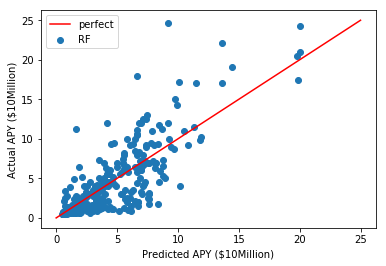

In [19]:
# Visualize the predictions

plt.scatter(Yval_hat, Yval)
plt.plot([0, 25], [0, 25], 'r-')
plt.xlabel('Predicted APY ($10Million)')
plt.ylabel('Actual APY ($10Million)')
plt.legend([ 'perfect', 'RF'])

## Export predictions for Kaggle

Check out the [Kaggle page](https://www.kaggle.com/c/nfl-free-agent-value) to submit to the first round of the competition!

In [20]:
pd.DataFrame({'Contract_ID': Xtest.index, 'APY_millions':Ytest_hat}).to_csv('rf_submission.csv', index=False)